#### 0. Import Required Libraries & Load *Dataset*

In [1]:
##Import Libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set()

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, StratifiedKFold

# from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import warnings
warnings.simplefilter(action='ignore')

In [ ]:
# Loading data with Pandas

df = pd.read_csv("bank_dataset.csv")
df.head()

,ID,Gender,Age,Region_Code,US_County,US_State,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Autauga,AL,Other,X3,43,No,1045696,No,0.0
1,IDD62UNG,Female,30,RG277,Baldwin,AL,Salaried,X1,32,No,581988,No,0.0
2,HD3DSEMC,Female,56,RG268,Autauga,AL,Self_Employed,X3,26,No,1484315,Yes,0.0
3,BF3NC7KV,Male,34,RG270,Barbour,AL,Salaried,X1,19,No,470454,No,0.0
4,TEASRWXV,Female,30,RG282,Bibb,AL,Salaried,X1,33,No,886787,No,0.0


In [ ]:
print("Count of rows in Dataset:",len(df))

Count of rows in Dataset: 351037


##### Extracting and Cleaning Open Source Demographic Dataset

###### Unemployment and median household income for the U.S., States, and counties, 2000–22 Dataset:

https://www.ers.usda.gov/data-products/county-level-data-sets/county-level-data-sets-download-data/

In [ ]:
# Skip the first 4 rows while reading the Excel file
demo_df1 = pd.read_excel("Unemployment.xlsx", skiprows=4)

# Display the first 2 rows of the DataFrame
demo_df1.head(2)

,FIPS_Code,State,Area_Name,Rural_Urban_Continuum_Code_2013,Urban_Influence_Code_2013,Metro_2013,Civilian_labor_force_2000,Employed_2000,Unemployed_2000,Unemployment_rate_2000,...,Civilian_labor_force_2021,Employed_2021,Unemployed_2021,Unemployment_rate_2021,Civilian_labor_force_2022,Employed_2022,Unemployed_2022,Unemployment_rate_2022,Median_Household_Income_2021,Med_HH_Income_Percent_of_State_Total_2021
0,0,US,United States,NaN,NaN,NaN,142601576.0,136904853.0,5696723.0,4.0,...,162229903.0,153544980.0,8684923.0,5.4,164781642.0,158766998.0,6014644.0,3.7,69717.0,NaN
1,1000,AL,Alabama,NaN,NaN,NaN,2147173.0,2047731.0,99442.0,4.6,...,2259349.0,2183330.0,76019.0,3.4,2286028.0,2226670.0,59358.0,2.6,53990.0,100.0


In [ ]:
# Extract relevent columns, columns with the latest information regarding US counties

demo_df1_cleaned = demo_df1[['Area_Name','Civilian_labor_force_2022', 'Employed_2022','Unemployed_2022', 'Unemployment_rate_2022','Median_Household_Income_2021','Med_HH_Income_Percent_of_State_Total_2021']]

# Extract rows related only to US counties
demo_df1_cleaned = demo_df1_cleaned[demo_df1_cleaned['Area_Name'].str.contains('County')]
demo_df1_cleaned = demo_df1_cleaned.reset_index(drop=True)

# Create 'County' Column
demo_df1_cleaned['County'] = demo_df1_cleaned['Area_Name'].str[:-10]
demo_df1_cleaned['State'] = demo_df1_cleaned['Area_Name'].str[-2:]


demo_df1_cleaned.drop(columns=['Area_Name'], inplace=True)

demo_df1_cleaned = pd.concat([demo_df1_cleaned['State'], demo_df1_cleaned.drop(columns=['State'])], axis=1)
demo_df1_cleaned = pd.concat([demo_df1_cleaned['County'], demo_df1_cleaned.drop(columns=['County'])], axis=1)


demo_df1_cleaned.head(2)

,County,State,Civilian_labor_force_2022,Employed_2022,Unemployed_2022,Unemployment_rate_2022,Median_Household_Income_2021,Med_HH_Income_Percent_of_State_Total_2021
0,Autauga,AL,26789.0,26181.0,608.0,2.3,66444.0,123.1
1,Baldwin,AL,102849.0,100432.0,2417.0,2.4,65658.0,121.6


In [ ]:
# Merge the 2 files
mergedDF = pd.merge(df, demo_df1_cleaned, left_on=['US_County', 'US_State'], right_on=['County', 'State'], how="left")
mergedDF = mergedDF[['ID', 'Gender', 'Age', 'Region_Code', 'US_County', 'US_State','Occupation', 'Channel_Code', 'Vintage', 'Credit_Product',
       'Avg_Account_Balance', 'Is_Active', 'Civilian_labor_force_2022', 'Employed_2022', 'Unemployed_2022',
       'Unemployment_rate_2022', 'Median_Household_Income_2021',
       'Med_HH_Income_Percent_of_State_Total_2021','Is_Lead']]
mergedDF.head(5)

,ID,Gender,Age,Region_Code,US_County,US_State,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Civilian_labor_force_2022,Employed_2022,Unemployed_2022,Unemployment_rate_2022,Median_Household_Income_2021,Med_HH_Income_Percent_of_State_Total_2021,Is_Lead
0,NNVBBKZB,Female,73,RG268,Autauga,AL,Other,X3,43,No,1045696,No,26789.0,26181.0,608.0,2.3,66444.0,123.1,0.0
1,IDD62UNG,Female,30,RG277,Baldwin,AL,Salaried,X1,32,No,581988,No,102849.0,100432.0,2417.0,2.4,65658.0,121.6,0.0
2,HD3DSEMC,Female,56,RG268,Autauga,AL,Self_Employed,X3,26,No,1484315,Yes,26789.0,26181.0,608.0,2.3,66444.0,123.1,0.0
3,BF3NC7KV,Male,34,RG270,Barbour,AL,Salaried,X1,19,No,470454,No,8241.0,7906.0,335.0,4.1,38649.0,71.6,0.0
4,TEASRWXV,Female,30,RG282,Bibb,AL,Salaried,X1,33,No,886787,No,8726.0,8507.0,219.0,2.5,48454.0,89.7,0.0


#### 1. Show overall descriptive statistics of your dataset; number of data points, number of descriptive features, type of features, your target feature and its type, descriptive features for different target feature values.

In [ ]:
print("Descriptive Statistics:")
print(mergedDF.describe())
print("\n\nNumber of Data Points: ", mergedDF.shape[0])
print("\n\nNumber of Descriptive Features:", len(mergedDF.columns))
print("\n\nType of Descriptive Features:")
print(mergedDF.dtypes)

target_feature_type = mergedDF['Is_Lead'].dtype
print("\n\nTarget Feature: Is_Lead")
print("\n\nType of Target Feature: ", mergedDF['Is_Lead'].dtype)

Descriptive Statistics:
                 Age        Vintage  Avg_Account_Balance  \
count  351037.000000  351037.000000         3.510370e+05   
mean       43.860716      46.924244         1.130141e+06   
std        14.841932      32.329303         8.569530e+05   
min        23.000000       7.000000         2.079000e+04   
25%        30.000000      20.000000         6.041850e+05   
50%        43.000000      32.000000         8.951620e+05   
75%        54.000000      73.000000         1.368152e+06   
max        85.000000     135.000000         1.035201e+07   

       Civilian_labor_force_2022  Employed_2022  Unemployed_2022  \
count              351037.000000  351037.000000    351037.000000   
mean                23811.416754   23187.491102       623.925652   
std                 23000.786912   22446.470860       565.174058   
min                  2740.000000    2620.000000       113.000000   
25%                  8241.000000    7906.000000       274.000000   
50%                 15933.0

#### 2. Determine if any features have missing data and what should be done with the missing data. Explain why the decision was made for each feature. If there is no missing data,explain how you would handle missing data and why. Provide supporting visualizations with their analysis.

In [ ]:
#To Determine if any feature have missing values

null_count_df = mergedDF.isnull().sum().reset_index()
null_feature = null_count_df[null_count_df.iloc[:, 1] > 0 ]
print("Features with missing values: ",null_feature.iloc[:,0].tolist())
print(f"Count of missing values in feature {null_feature.iloc[:,0].tolist()}:  ",null_feature.iloc[:,1].tolist()," respectively")


Features with missing values:  ['Credit_Product']
Count of missing values in feature ['Credit_Product']:   [41847]  respectively


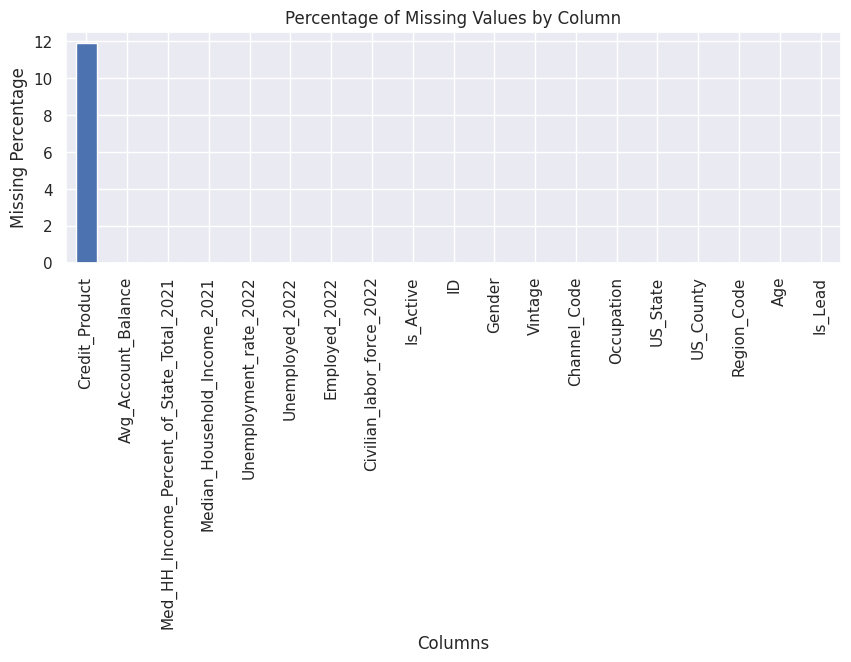

In [ ]:
#Visualization for missing values analysis

missing_percentage = (mergedDF.isnull().mean() * 100).sort_values(ascending=False)
plt.figure(figsize=(10, 3))
missing_percentage.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Missing Percentage')
plt.title('Percentage of Missing Values by Column')
plt.show()


In [ ]:
# Distinct values present in feature Credit_Product

print("Distinct values present in feature Credit_Product:\t" , mergedDF.Credit_Product.unique().tolist())
print("Number of No and Yes values present for Non-Null values in Credit_Product:\t" ,mergedDF.Credit_Product.value_counts().tolist()," respectively" )

Distinct values present in feature Credit_Product:	 ['No', nan, 'Yes']
Number of No and Yes values present for Non-Null values in Credit_Product:	 [205965, 103225]  respectively


In [ ]:
## To select missing value treatment for Credit_Product, following points need to be taken into account:
## 1. Credit_Product: stands for whether Customer has already bought other Credit Product (eg: Loan, Other Credit Card, etc)
## 2. Missing values for Credit_Product is 12% of total numbers of variable it wouldn't be recommended to drop rows with Null values
## 3. Credit_Product has only two outputs('No' & 'Yes')
##
## Best missing value Treatmemt would be KNN Imputer since
## a. Credit_Product intutively depends on other features
## b. Filling with Mode or "0" doesn't is as good as feeling randomanly as there are "No": 205965 and "Yes": 103225 not null values

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

revampedDF1 = mergedDF
imputed_df = mergedDF

# Encode Credit_Product
def enocode_Credit_Product(value):
    if value == 'Yes':
        return 1
    elif value == 'No':
        return 0
    else:
        return value

imputed_df['Credit_Product_encoded'] = imputed_df['Credit_Product'].apply(enocode_Credit_Product)
imputed_df = imputed_df.drop(['Credit_Product'], axis=1) #Replaced Credit_Product with Credit_Product_encoded

# Select features for imputation
features_list = imputed_df.columns.tolist()
features_list.remove('ID') #Removing ID column
features_list.remove('Region_Code') #Removing ID column
features_list.remove('Is_Lead') #Removing Target Variable

# Scaling Numerical features
scaler = StandardScaler()
scaled_feature_list = ['Age', 'Vintage','Avg_Account_Balance','Civilian_labor_force_2022', 'Employed_2022', 'Unemployed_2022','Unemployment_rate_2022', 'Median_Household_Income_2021','Med_HH_Income_Percent_of_State_Total_2021']
scaled_features = scaler.fit_transform(imputed_df[scaled_feature_list])
imputed_df[scaled_feature_list] = scaled_features

# Labeling Categorical features
labelled_feature_list = ['Gender', 'US_County', 'US_State','Occupation', 'Channel_Code', 'Is_Active']

# Apply label encoding to selected columns
label_encoders = {}
for feature in labelled_feature_list:
    label_encoder = LabelEncoder()
    imputed_df[feature] = label_encoder.fit_transform(imputed_df[feature])
    label_encoders[feature] = label_encoder

# Apply KNN imputer only on selected features
imputer = KNNImputer(n_neighbors=3) # With binary features, using a small k value allows the algorithm to focus on very local patterns
revampedDF1['Credit_Product_encoded'] = imputer.fit_transform(imputed_df['Credit_Product_encoded'].values.reshape(-1, 1))

revampedDF1 = revampedDF1.drop(['Credit_Product'], axis=1) #Replaced Credit_Product with Credit_Product_encoded

In [ ]:
# No missing value column present
revampedDF1.isnull().sum()

ID                                           0
Gender                                       0
Age                                          0
Region_Code                                  0
US_County                                    0
US_State                                     0
Occupation                                   0
Channel_Code                                 0
Vintage                                      0
Avg_Account_Balance                          0
Is_Active                                    0
Civilian_labor_force_2022                    0
Employed_2022                                0
Unemployed_2022                              0
Unemployment_rate_2022                       0
Median_Household_Income_2021                 0
Med_HH_Income_Percent_of_State_Total_2021    0
Is_Lead                                      0
Credit_Product_encoded                       0
dtype: int64

#### 3. Explore your features further in their distributions and plot their bar and box plots. How are individual features distributed? Show outliers for each feature. Do you think any of the outliers may impact your analysis? Why? Provide supporting visualizations with their analysis.

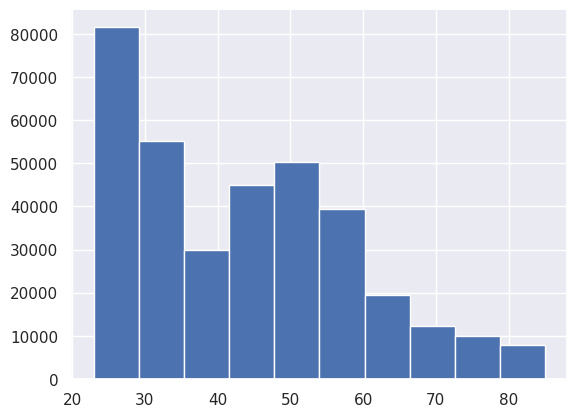

In [ ]:
plt.hist(revampedDF1['Age'])
plt.show()

[Text(0.5, 1.0, 'Gender Against Credit Card Lead')]

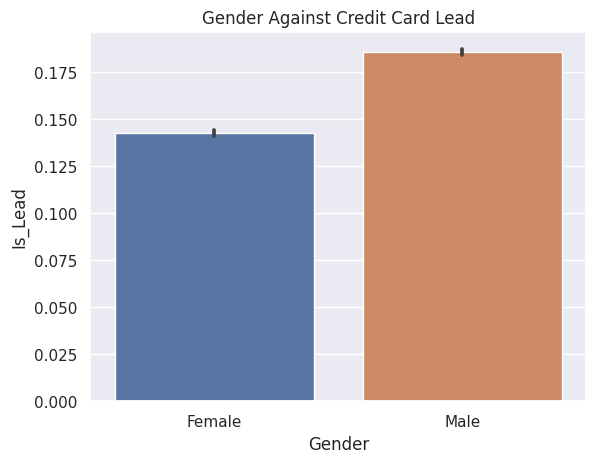

In [ ]:
sns.barplot(x=revampedDF1.Gender,y=revampedDF1.Is_Lead).set(title="Gender Against Credit Card Lead")

[Text(0.5, 1.0, 'Occupation Against Credit Card Lead')]

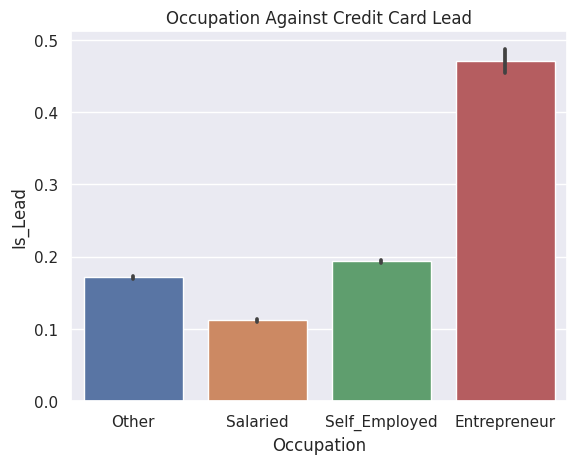

In [ ]:
sns.barplot(x=revampedDF1.Occupation,y=revampedDF1.Is_Lead).set(title="Occupation Against Credit Card Lead")

[Text(0.5, 1.0, 'Region Against Credit Card Lead')]

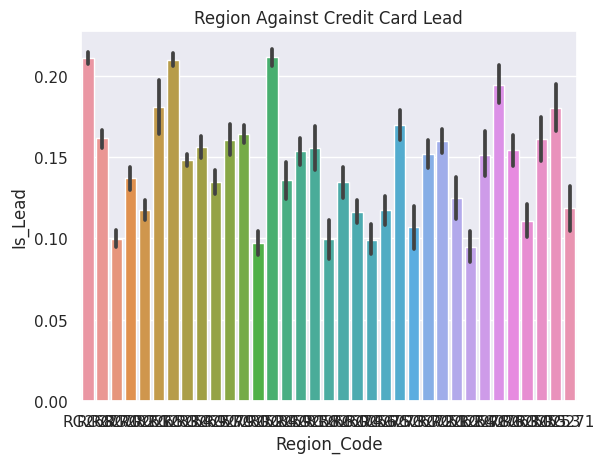

In [ ]:
sns.barplot(x=revampedDF1.Region_Code,y=revampedDF1.Is_Lead).set(title="Region Against Credit Card Lead")

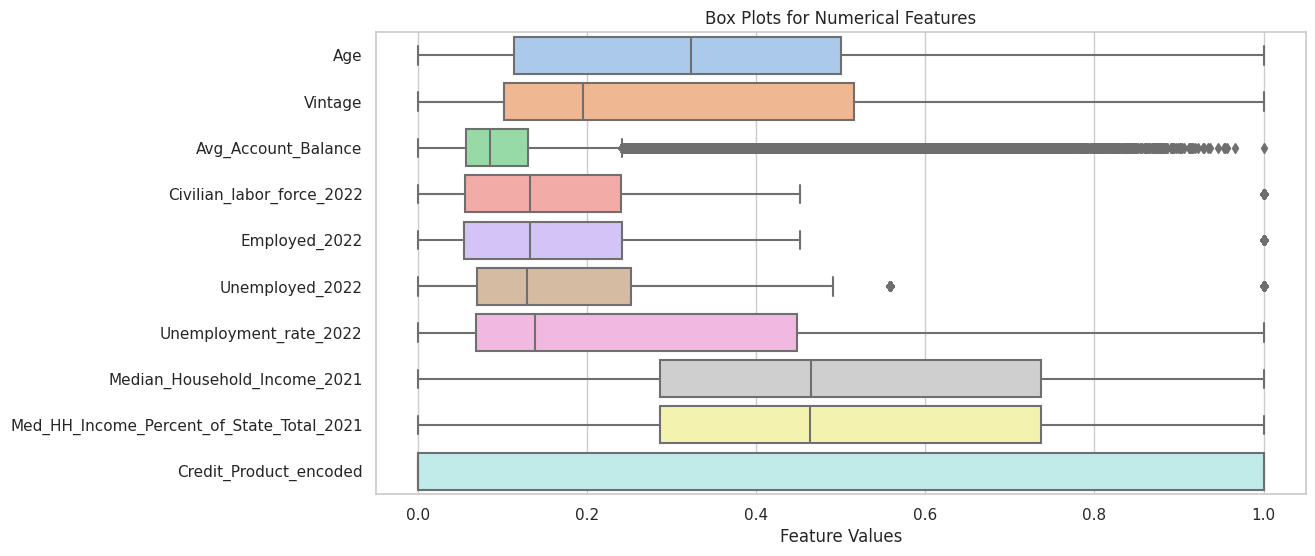

In [ ]:
# For Box Plot Visualization

from sklearn.preprocessing import StandardScaler, MinMaxScaler

numerical_columns = revampedDF1.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_columns.remove('Is_Lead')

data_for_boxplot = revampedDF1[numerical_columns]

# MinMax scaling on numerical columns for better box plot interpretation
scaler = MinMaxScaler()
data_for_boxplot[numerical_columns] = scaler.fit_transform(data_for_boxplot[numerical_columns])

# Set the style of the visualization
sns.set(style="whitegrid", palette="pastel")

# Plot box plots for all numerical features
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_for_boxplot, orient="h")
plt.title("Box Plots for Numerical Features")
plt.xlabel("Feature Values")
plt.show()


In [ ]:
# From the box plot we can interpret Avg_Account_Balance has high number of Outliers and Civilian_labor_force_2022 has also have outliers though relatively less
# We can cap Outliers instead of removing outlier values because because removing will lead to loss of data

for feature in ('Avg_Account_Balance','Civilian_labor_force_2022'):
  # Calculate the IQR for the specified feature
  Q1 = revampedDF1[feature].quantile(0.25)
  Q3 = revampedDF1[feature].quantile(0.75)
  IQR = Q3 - Q1

  # Set lower and upper bounds for capping outliers
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Capping outliers in the specified feature
  revampedDF1[feature] = revampedDF1[feature].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

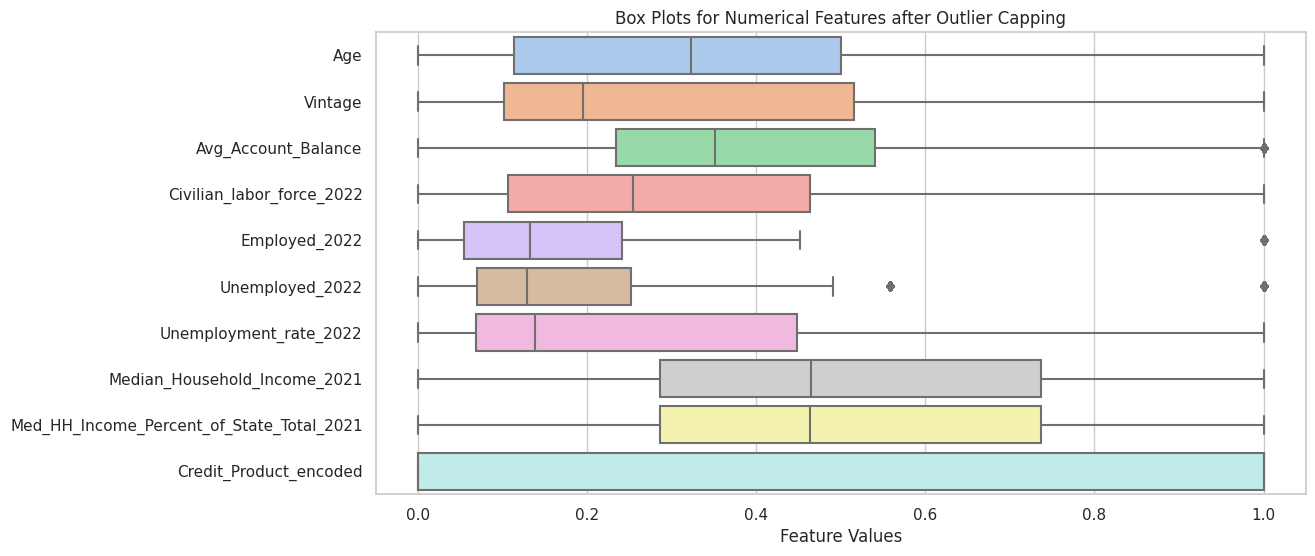

In [ ]:
numerical_columns = revampedDF1.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_columns.remove('Is_Lead')

data_for_boxplot = revampedDF1[numerical_columns]

# MinMax scaling on numerical columns for better box plot interpretation
scaler = MinMaxScaler()
data_for_boxplot[numerical_columns] = scaler.fit_transform(data_for_boxplot[numerical_columns])

# Set the style of the visualization
sns.set(style="whitegrid", palette="pastel")

# Plot box plots for all numerical features
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_for_boxplot, orient="h")
plt.title("Box Plots for Numerical Features after Outlier Capping")
plt.xlabel("Feature Values")
plt.show()

#### 4. What data pre-processing techniques do you apply? E.g., encoding features, missing values, scaling, etc. Explain each process and why you use it.

In [ ]:
revampedDF2=revampedDF1

# Removing Features that are IDs, Region_code, US_State and US_County

columns_to_remove = ['ID', 'Region_Code','US_State','US_County']
revampedDF2 = revampedDF2.drop(columns=columns_to_remove, axis=1)

In [ ]:
# Missing Value has ben treated in Q2 using KNN Imputer

In [ ]:
# One-hot encoding is necessary in many machine learning algorithms because these algorithms often require numerical input, and categorical variables cannot be directly used as input.
# By converting categorical variables into one-hot encoded vectors, you create a numerical representation that machine learning algorithms can work with.

from sklearn.preprocessing import OneHotEncoder

# One-hot encode the columns
one_hot_encoded = pd.get_dummies(revampedDF2,columns=['Gender','Occupation', 'Channel_Code', 'Is_Active'])

# Concatenate the one-hot encoded columns with the original DataFrame
revampedDF2 = one_hot_encoded

In [ ]:
print("Columns after One Hot Encoding:",one_hot_encoded.columns)

Columns after One Hot Encoding: Index(['Age', 'Vintage', 'Avg_Account_Balance', 'Civilian_labor_force_2022',
       'Employed_2022', 'Unemployed_2022', 'Unemployment_rate_2022',
       'Median_Household_Income_2021',
       'Med_HH_Income_Percent_of_State_Total_2021', 'Is_Lead',
       'Credit_Product_encoded', 'Gender_Female', 'Gender_Male',
       'Occupation_Entrepreneur', 'Occupation_Other', 'Occupation_Salaried',
       'Occupation_Self_Employed', 'Channel_Code_X1', 'Channel_Code_X2',
       'Channel_Code_X3', 'Channel_Code_X4', 'Is_Active_No', 'Is_Active_Yes'],
      dtype='object')


In [ ]:
# Min-max scaling is a technique used in data preprocessing to scale numeric features within a specific range, typically 0 to 1. It is required in many machine learning algorithms
# because it ensures that all features have the same scale, preventing certain features from dominating the learning process due to their larger magnitude.

# Separate numerical columns from categorical columns
numerical_columns = revampedDF2.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = revampedDF2.select_dtypes(include=['object']).columns.tolist()
numerical_columns.remove('Is_Lead')

# MinMax scaling on numerical columns
scaler = MinMaxScaler()
revampedDF2[numerical_columns] = scaler.fit_transform(revampedDF2[numerical_columns])

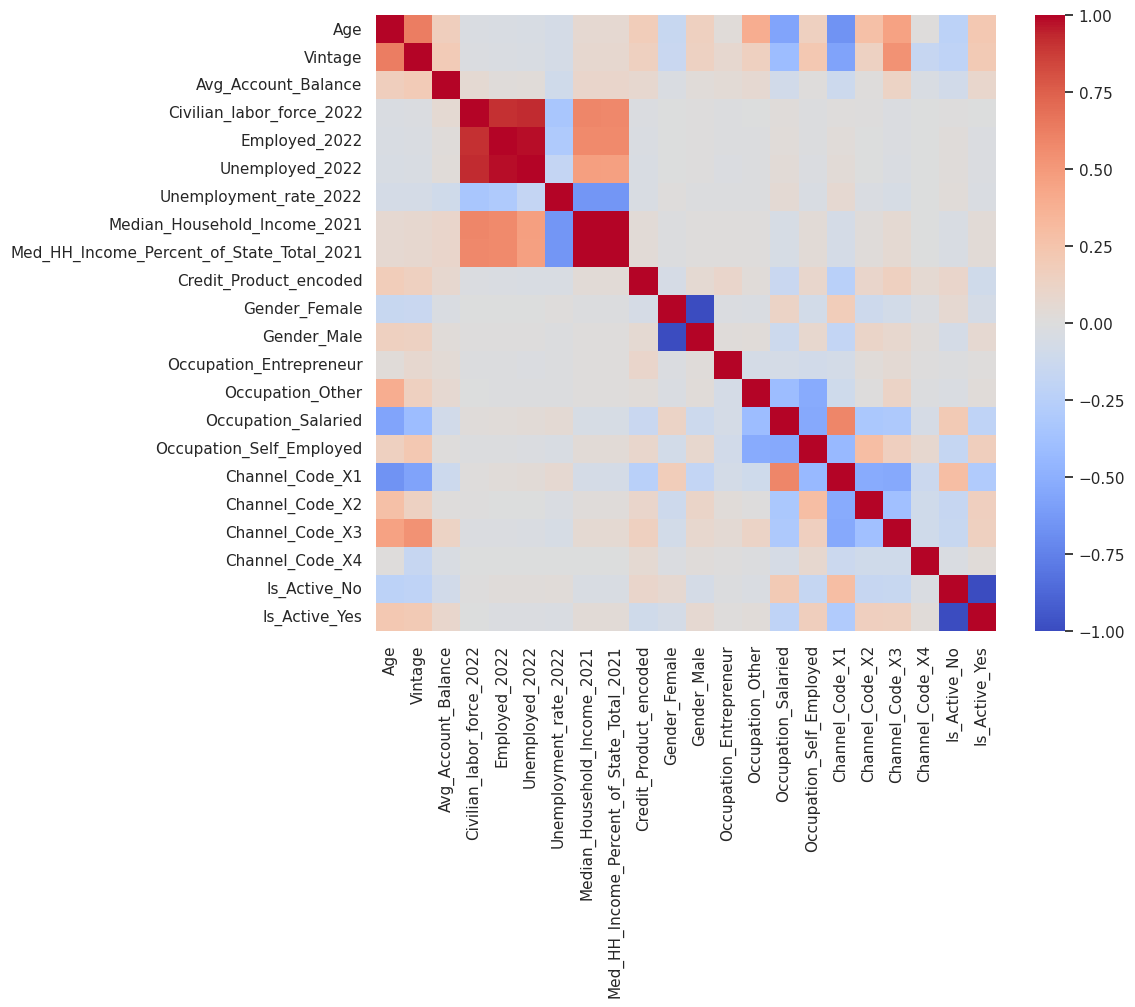

In [ ]:
# Removing highly correlated features is essential in machine learning for several reasons. Highly correlated features can introduce multicollinearity, making it challenging for the
# model to differentiate the individual effects of these features on the target variable and also leading to overfitting and poor generalization to new, unseen data

list_of_columns = revampedDF2.columns.tolist()
list_of_columns.remove('Is_Lead')

#Correaltion of all features
correlation_matrix = revampedDF2[list_of_columns].corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()

In [ ]:
# Removing one of from the feature pair which are Highly Correalted with correaltion more than 70%

threshold = 0.7

# Find and remove correlated features
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

print("Features to drop: ",to_drop)

# Drop the correlated features from the DataFrame
revampedDF2 = revampedDF2.drop(columns=to_drop)

revampedDF2.head()

Features to drop:  ['Employed_2022', 'Unemployed_2022', 'Med_HH_Income_Percent_of_State_Total_2021']


,Age,Vintage,Avg_Account_Balance,Civilian_labor_force_2022,Unemployment_rate_2022,Median_Household_Income_2021,Is_Lead,Credit_Product_encoded,Gender_Female,Gender_Male,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X1,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Is_Active_No,Is_Active_Yes
0,0.806452,0.281250,0.411062,0.463631,0.068966,1.000000,0.0,0.0,1,0,0,1,0,0,0,0,1,0,1,0
1,0.112903,0.195312,0.225081,1.000000,0.103448,0.978299,0.0,0.0,1,0,0,0,1,0,1,0,0,0,1,0
2,0.532258,0.148438,0.586980,0.463631,0.068966,1.000000,0.0,0.0,1,0,0,0,0,1,0,0,1,0,0,1
3,0.177419,0.093750,0.180348,0.106052,0.689655,0.232585,0.0,0.0,0,1,0,0,1,0,1,0,0,0,1,0
4,0.112903,0.203125,0.347328,0.115402,0.137931,0.503299,0.0,0.0,1,0,0,0,1,0,1,0,0,0,1,0


#### 5. Analyze distribution of your target variable. Is it balanced or imbalanced? Do you think any of these may cause a problem and why? Provide supporting visualizations with their analysis.

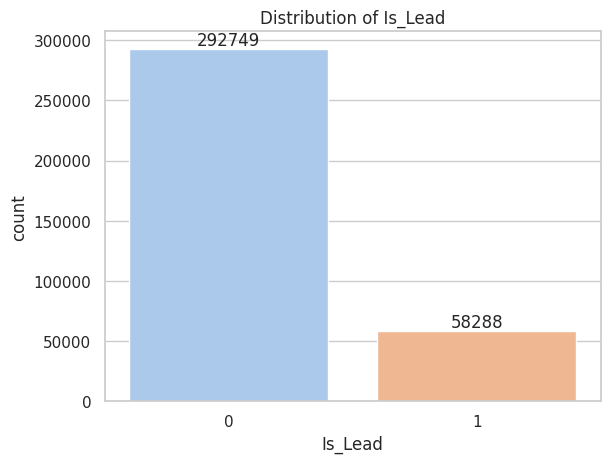

In [ ]:
revampedDF3 = revampedDF2;
revampedDF3['Is_Lead'] = revampedDF3['Is_Lead'].astype(int)  #Changing datatype of Is_Lead from float to int

sns.countplot(x='Is_Lead', data=revampedDF3)

# Calculate count values for 0s and 1s
counts = revampedDF3['Is_Lead'].value_counts()

# Annotate the count values on top of the bars
for index, value in enumerate(counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.title('Distribution of Is_Lead')
plt.show()

In [ ]:
#Distribution of Target variable(Is_Lead) is unbalanced as 1s are 58,288 while 0s are 292,749, hence, it is biased towards 0.
#Now, to overcome this, we have 2 approaches- Undersampling and Oversampling. We can't use Undersampling as it will delete a few rows due to which
#we will loose the data. Therefore, we use Oversampling which will balance the distribution of Target variable.

In [ ]:
#Oversampling the target variable(Is_Lead)

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = revampedDF3.copy()
X.drop('Is_Lead', axis=1, inplace=True)
Y = revampedDF3["Is_Lead"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data only to avoid data leakage
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Export test and train data for further use
X_test.to_csv('X_test.csv', index=False)
Y_test.to_csv('Y_test.csv', index=False)
X_train_resampled.to_csv('X_train.csv', index=False)
Y_train_resampled.to_csv('Y_train.csv', index=False)

# Now X_train_resampled and y_train_resampled contain the oversampled data

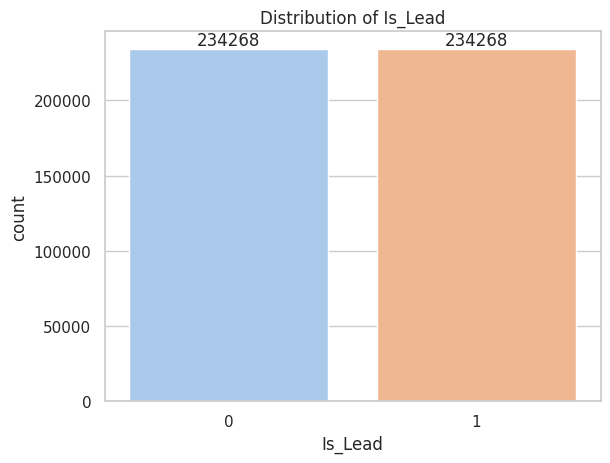

In [ ]:
df_Y_train_resampled = Y_train_resampled.to_frame(name='Is_Lead')
sns.countplot(x='Is_Lead', data=df_Y_train_resampled)
# Calculate count values for 0s and 1s
counts = df_Y_train_resampled['Is_Lead'].value_counts()
# Annotate the count values on top of the bars
for index, value in enumerate(counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.title('Distribution of Is_Lead')
plt.show()

#### 6. What kind of ML approaches and algorithms do you choose to use and why? E.g.,supervised, regression, classification, binary, multi-class, split rate of data, logistic regression, SVM, decision trees etc. Provide supporting visualizations with their analysis.

In [ ]:
# We would be choosing Binary Classifier Machine Learning Models, since our Target Variable is a Binary output (1,0)
# Following are the models that we can choose from: Logistic regression, Decision Trees, Random Forest, Boosted Forest, SVM, KNN, Naive Bayes, Neural Networks
# We would be utilizing Logistic regression as it is a good starting point for binary classification problems


from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
model = LogisticRegression()

# Train the model on the training data
model.fit(X_train_resampled, Y_train_resampled)


LogisticRegression()

In [ ]:
# Running model on the test data

Y_pred = model.predict(X_test)

print("Y Prediction:",Y_pred)

Y Prediction: [0 0 0 ... 1 0 1]


####7. What evaluation metrics you used to evaluate the performance of your model. Discuss the results of your model as to which model performs better and why this would be the case. How would your model perform based on the results? What shortcomings your model has and possible implications? What would you do to improve the results?

In [ ]:
# Evalution Metrics

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy :\t",accuracy)

from sklearn.metrics import precision_score
precision = precision_score(Y_test, Y_pred)
print("Precision :\t",precision)

from sklearn.metrics import recall_score
recall = recall_score(Y_test, Y_pred)
print("Recall :\t",recall)

from sklearn.metrics import f1_score
f1 = f1_score(Y_test, Y_pred)
print("F1-Score :\t",f1)

from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(Y_test, model.predict_proba(X_test)[:, 1])
auc = roc_auc_score(Y_test, Y_pred)
print("AUC :\t\t",auc)

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix :\t",conf_matrix)

Accuracy :	 0.6686275068368277
Precision :	 0.2965653431130545
Recall :	 0.7171484608169182
F1-Score :	 0.4196083322938755
AUC :		 0.6880231112415502
Confusion Matrix :	 [[38533 19948]
 [ 3317  8410]]


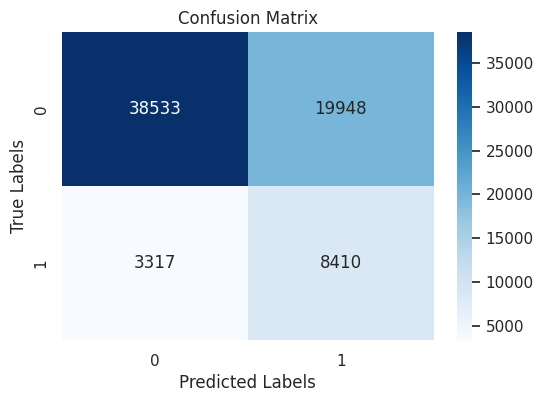

In [ ]:
# Visualization of Confusion Matrix

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

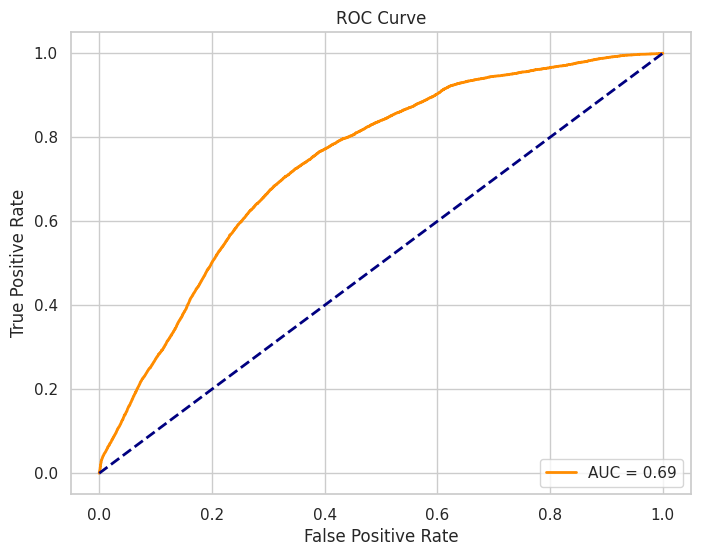

In [ ]:
# Visualization of ROC AUC Curve

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Performance Analysis, Shortcomings and Possible Implications:
# The model correctly predicts about 66.8% of the instances in the test data.
# Precision indicates that only about 29.6% of the instances predicted as positive are actually positive. This means there is a high rate of false positives.
# Recall, also known as sensitivity, is relatively higher at 71.8%. It means the model captures 71.8% of all actual positive instances.
# However, considering precision, there are still many false positives.
# The AUC-ROC score is 0.688, indicating that the model has a moderate ability to discriminate between positive and negative instances.

# Improvements:
# Model Complexity: The logistic regression model might be too simple to capture the underlying patterns in the data. More complex models or ensemble methods could be explored.
# Model Selection: Experiment with more complex algorithms such as random forests, gradient boosting, or neural networks to capture intricate patterns in the data.

# Hyperparameter Tuning: Fine-tuning hyperparameters (e.g., regularization strength) can help improve the model's performance.
# Hyperparameter Tuning: Utilize techniques like grid search or random search to find the optimal hyperparameters for your model, which might improve its performance.
# Regularization: Experiment with different regularization techniques (L1, L2) to prevent overfitting and improve generalization to unseen data.
# Cross-Validation: Implement cross-validation techniques to get a more reliable estimate of your model's performance and reduce the risk of overfitting.

#### 8. Reflect on your thought process, steps and explain what kind of stages and processes you have gone through to make decisions in each step. For instance, what led you to choose the evaluation metric you use? what motivated your selection of ML algorithms for prediction? why did you choose the preprocessing techniques you used? Provide supporting visualizations with their analysis.

**Understanding the Problem:**

1. Thought Process: Started by understanding the problem context. Identified it as a binary classification problem from the requirement and dataset provided

**Data Exploration and Preprocessing:**
1. Thought Process: Examined the dataset to understand its structure, missing values, and data types. Decided to handle missing values if any, and checked for outlier to inform subsequent steps.
2. Decision-Making: Chose appropriate preprocessing techniques like handling missing values and addressing outliers


**Feature Selection and Engineering:**
1. Thought Process: Explored the features to identify potential correlation relationships, encoding values and scaling requirement
2. Decision-Making: Conducted One-Hot Encoding since categorical columns had limited values, Min Max scaling was conducted to get numerical features to comparable values and used correlation between features to remove highly correalted features

**Model Selection:**
1. Thought Process: Considered the nature of the problem (binary classification) and the need for interpretable results.
2. Decision-Making: Chose logistic regression as it is a good starting point for binary classification problems. Considered more complex models for future iterations based on the initial results.

**Choosing Evaluation Metrics:**
1. Thought Process: Evaluated the model's performance based on the problem's context. Considered the implications of false positives and false negatives. Balanced accuracy, precision, recall, F1-score, and AUC-ROC were chosen to comprehensively assess the model's performance.

2. Decision-Making:Visualized the confusion matrix, ROC curve, and precision-recall curve to gain a deep understanding of the model's strengths and weaknesses. Interpreted these visualizations to assess the model's effectiveness.

**Iterative Improvement:**
1. Thought Process: Analyzed the model's shortcomings and potential reasons for its performance. Brainstormed possible improvements and areas to focus on for enhancing the model's predictive power.

2. Decision-Making: Provided suggestions for addressing class imbalance, feature engineering, model complexity, hyperparameter tuning, and cross-validation to iteratively enhance the model. Encouraged experimentation and continuous improvement.

## Project-2

In [ ]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# Create Decision Tree classifer object
DTCModel = DecisionTreeClassifier()

# Train Decision Tree Classifer
DTCModel = DTCModel.fit(X_train_resampled, Y_train_resampled)

# Predict the response for test dataset
Y_pred = DTCModel.predict(X_test)
print("Y Prediction:", Y_pred)

# Evaluation Metrics
print("\nEvaluation Metrics:")

# Model Accuracy
print("Accuracy:\t", metrics.accuracy_score(Y_test, Y_pred))

# Precision Score
print("Precision :\t", metrics.precision_score(Y_test, Y_pred))

# Recall
print("Recall :\t", metrics.recall_score(Y_test, Y_pred))

# F1 Score
print("F1-Score :\t", metrics.f1_score(Y_test, Y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", metrics.confusion_matrix(Y_test, Y_pred))

# Classification Report
print("Classification Report:\n", metrics.classification_report(Y_test, Y_pred))

Y Prediction: [0 0 0 ... 1 0 0]

Evaluation Metrics:
Accuracy:	 0.7882577484047402
Precision :	 0.3782672768168774
Recall :	 0.41587788863306896
F1-Score :	 0.3961819658813973
Confusion Matrix:
 [[50465  8016]
 [ 6850  4877]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87     58481
           1       0.38      0.42      0.40     11727

    accuracy                           0.79     70208
   macro avg       0.63      0.64      0.63     70208
weighted avg       0.80      0.79      0.79     70208



In [ ]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

RFModel = RandomForestClassifier()
RFModel.fit(X_train_resampled, Y_train_resampled)

Y_pred = RFModel.predict(X_test)
print("Y Prediction:", Y_pred)

# Evaluation Metrics
print("\nEvaluation Metrics:")

# Model Accuracy
print("Accuracy:\t", metrics.accuracy_score(Y_test, Y_pred))

# Precision Score
print("Precision :\t", metrics.precision_score(Y_test, Y_pred))

# Recall
print("Recall :\t", metrics.recall_score(Y_test, Y_pred))

# F1 Score
print("F1-Score :\t", metrics.f1_score(Y_test, Y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", metrics.confusion_matrix(Y_test, Y_pred))

# Classification Report
print("Classification Report:\n", metrics.classification_report(Y_test, Y_pred))

Y Prediction: [0 0 1 ... 0 0 1]

Evaluation Metrics:
Accuracy:	 0.8286947356426618
Precision :	 0.48848633712004913
Recall :	 0.5426792871152042
F1-Score :	 0.5141587558069076
Confusion Matrix:
 [[51817  6664]
 [ 5363  6364]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90     58481
           1       0.49      0.54      0.51     11727

    accuracy                           0.83     70208
   macro avg       0.70      0.71      0.71     70208
weighted avg       0.84      0.83      0.83     70208



In [ ]:
# XGBoost

import xgboost as xgb

XGB_Model = xgb.XGBClassifier()
XGB_Model.fit(X_train_resampled, Y_train_resampled)

Y_pred = XGB_Model.predict(X_test)
print("Y Prediction:", Y_pred)

# Evaluation Metrics
print("\nEvaluation Metrics:")

# Model Accuracy
print("Accuracy:\t", metrics.accuracy_score(Y_test, Y_pred))

# Precision Score
print("Precision :\t", metrics.precision_score(Y_test, Y_pred))

# Recall
print("Recall :\t", metrics.recall_score(Y_test, Y_pred))

# F1 Score
print("F1-Score :\t", metrics.f1_score(Y_test, Y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", metrics.confusion_matrix(Y_test, Y_pred))

# Classification Report
print("Classification Report:\n", metrics.classification_report(Y_test, Y_pred))

Y Prediction: [0 0 0 ... 0 0 1]

Evaluation Metrics:
Accuracy:	 0.8529369872379216
Precision :	 0.5644894204231831
Recall :	 0.523236974503283
F1-Score :	 0.5430809399477806
Confusion Matrix:
 [[53747  4734]
 [ 5591  6136]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91     58481
           1       0.56      0.52      0.54     11727

    accuracy                           0.85     70208
   macro avg       0.74      0.72      0.73     70208
weighted avg       0.85      0.85      0.85     70208



In [ ]:
# Cross Validation

from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5)

score_DTC = cross_val_score(DTCModel, X_train_resampled, Y_train_resampled, cv=kf)
print("Cross Validation Scores for Decision Tree: {} ".format(score_DTC))
print("Average Cross Validation score for Decision Tree: {}".format(score_DTC.mean()))

score_RF = cross_val_score(RFModel, X_train_resampled, Y_train_resampled, cv=kf)
print("\nCross Validation Scores for Random Forest: {}".format(score_RF))
print("Average Cross Validation score for Random Forest: {}".format(score_RF.mean()))

score_XGB = cross_val_score(XGB_Model, X_train_resampled, Y_train_resampled, cv=kf)
print("\nCross Validation Scores for XGBoost: {}".format(score_XGB))
print("Average Cross Validation score for XGBoost: {}".format(score_XGB.mean()))

Cross Validation Scores for Decision Tree: [0.79623938 0.79934263 0.796504   0.96657667 0.96411154] 
Average Cross Validation score for Decision Tree: 0.8645548438443619

Cross Validation Scores for Random Forest: [0.84194519 0.8427332  0.84377901 0.93655757 0.93541571]
Average Cross Validation score for Random Forest: 0.8800861366916207

Cross Validation Scores for XGBoost: [0.84591497 0.84475013 0.84430192 0.91017747 0.91550258]
Average Cross Validation score for XGBoost: 0.8721294120717346
